# System

In [63]:
%conda install tqdm

Solving environment: done

## Package Plan ##

  environment location: /home/prang/miniconda3/envs/numbat

  added / updated specs:
    - tqdm


The following NEW packages will be INSTALLED:

  tqdm               pkgs/main/noarch::tqdm-4.59.0-pyhd3eb1b0_1


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [194]:
import sys
import os
import io
import glob
import random

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

import tqdm

In [352]:
import torch
import torch.nn as nn

from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset

torch.cuda.is_available()

True

In [196]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [197]:
fp_repo         = "/home/prang/dev/numbat"
fp_data         = f"{fp_repo}/data"
fp_data_mars32k = f"{fp_data}/mars32k"
fp_data_msl     = f"{fp_data}/msl-images"
fn_msl_label_names = f"msl_synset_words-indexed.txt"
fn_msl_train    = f"train-calibrated-shuffled.txt"
fn_msl_test     = f"test-calibrated-shuffled.txt"
fn_msl_val      = f"val-calibrated-shuffled.txt"

# Helpers

In [240]:
def plot_instance(inst):
    """ 
    Plots an potentially labelled instance
    """
    
    # Require WHC, not CWH
    im = np.einsum('ijk->jki', inst['image'])
    #im = inst['image']
    
    # Make plot
    plt.subplot(111)
    
    # Provide label information if we have it (through the title)
    text = inst['filename']
    if "label" in inst.keys():
        text = f"{text}\n{inst['label_name']} ({inst['label']})"
    plt.title(text)
    
    plt.imshow(im)
    plt.show()
    

# Data Science

## Loaders

### mars32k

In [241]:
class DatasetMars32k(Dataset):
    def __init__(self, fp_root, transform=None):
        """ 
        Reads all the image file names in the provided dataset folder. Note that there are
        no labels here
        """
        
        self.fp_root   = fp_root
        self.transform = transform
        self.filenames = [ os.path.basename(fp) for fp in glob.glob(f"{fp_root}/*.jpg") ]
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        """ 
        An instance in this dataset is just an image. This returns that image with the
        desired transforms + the filename
        """
        
        # Load image
        image = read_image(f"{self.fp_root}/{self.filenames[idx]}")
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        # Return as a dict
        instance = {
            'image': image,
            'filename': self.filenames[idx],
        }
        
        # TODO HDF5 / bmp efficiency
        return instance
    

In [242]:
dataset_mars32k = DatasetMars32k(fp_data_mars32k)

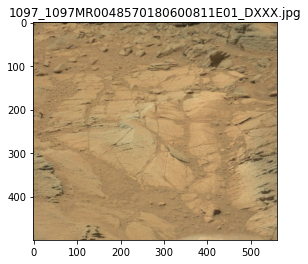

In [243]:
plot_instance(dataset_mars32k[100])

### msl

In [244]:
class DatasetMSL(Dataset):
    def __init__(self, fp_root, fn_pairs, transform=None):
        """ 
        Reads all the image files in the provided dataset folder. Also reads the label
        information
        """
        
        # Save what was provided
        self.fp_root   = fp_root
        self.transform = transform
        
        # Load the names of the classes for this dataset
        with open(f"{self.fp_root}/{fn_msl_label_names}", 'r') as f:
            self.label_name_map = [' '.join(ss.split()[1:]) for ss in f.readlines()]
        
        # Load the filename / label pairs from the provided file
        pairs = np.genfromtxt(f"{self.fp_root}/{fn_pairs}", dtype=None, encoding=None)
        self.filenames = [p[0] for p in pairs]
        self.labels    = [p[1] for p in pairs]
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        """ 
        An instance in this dataset is the image, label, and associated info
        """
        
        # Load image
        image = read_image(f"{self.fp_root}/{self.filenames[idx]}")
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        # Return as a dict
        instance = { 
            'image': image,
            'filename': self.filenames[idx],
            'label': self.labels[idx],
            'label_name': self.label_name_map[self.labels[idx]]
        }
        
        # TODO HDF5 / bmp efficiency
        return instance
    

In [245]:
# Load the datasets
dataset_msl_train = DatasetMSL(fp_data_msl, fn_msl_train)
dataset_msl_test  = DatasetMSL(fp_data_msl, fn_msl_test)
dataset_msl_val   = DatasetMSL(fp_data_msl, fn_msl_val)

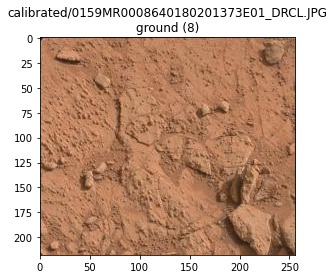

In [246]:
plot_instance(dataset_msl_train[9])

## Analysis

In [264]:
def dataset_statistics(dataset, rgb=False):
    
    # We'll create a pandas dataset and get the stats from there
    data = []
    
    labelled = "label" in dataset[0].keys()
    
    for i, inst in tqdm.tqdm(enumerate(dataset), total=(len(dataset))):
        # Get the image information
        im = inst['image'].numpy()
        dims = im.shape
        channels = dims[0]
        width    = dims[1]
        height   = dims[2]
        name = inst['filename']
        im_max = np.max(im)
        im_min = np.min(im)
        
        row = [name, channels, width, height, im_min, im_max]
        
        # Also want image mean and std
        if rgb:
            mean_r = np.mean(im[0])
            mean_g = np.mean(im[1])
            mean_b = np.mean(im[2])
            std_r = np.std(im[0])
            std_g = np.std(im[1])
            std_b = np.std(im[2])
            row.extend([mean_r, mean_g, mean_b, std_r, std_g, std_b])
        
        # And label information if it exists
        if labelled:
            label = inst['label']
            row.append(label)
            
        data.append(row)
     
    # Initialise the data frame object
    cols = ["name", "channels", "width", "height", "min value", "max value"]
    if labelled:
        cols.append("label")
    if rgb:
        cols.extend(["mean r", "mean g", "mean b", "std r", "std g", "std b"])
    df = pd.DataFrame(data, columns=cols)
    
    #print(df)
    
    # Return statistics
    print(df.describe())
    df.hist()

100%|██████████| 3746/3746 [00:02<00:00, 1500.55it/s]


          channels       width       height    min value    max value  \
count  3746.000000  3746.00000  3746.000000  3746.000000  3746.000000   
mean      2.924186   217.79071   255.539509     8.270155   246.050988   
std       0.381994    31.68579     0.498503    18.069312    13.224681   
min       1.000000    85.00000   255.000000     0.000000   172.000000   
25%       3.000000   192.00000   255.000000     0.000000   241.000000   
50%       3.000000   209.00000   256.000000     0.000000   255.000000   
75%       3.000000   255.00000   256.000000     7.000000   255.000000   
max       3.000000   256.00000   256.000000   138.000000   255.000000   

             label  
count  3746.000000  
mean     10.383075  
std       5.084684  
min       0.000000  
25%       8.000000  
50%       8.000000  
75%      10.000000  
max      24.000000  


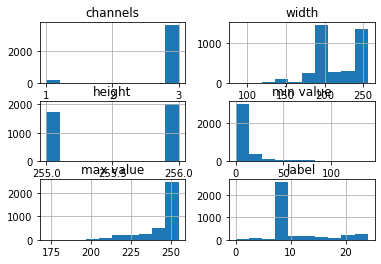

In [265]:
dataset_statistics(dataset_msl_train)

100%|██████████| 1305/1305 [00:00<00:00, 1582.26it/s]


          channels        width       height    min value    max value  \
count  1305.000000  1305.000000  1305.000000  1305.000000  1305.000000   
mean      2.954023   210.757854   255.672031     7.085824   247.502682   
std       0.299848    27.840220     0.469654    14.026552    12.641659   
min       1.000000   109.000000   255.000000     0.000000   196.000000   
25%       3.000000   192.000000   255.000000     0.000000   243.000000   
50%       3.000000   192.000000   256.000000     0.000000   255.000000   
75%       3.000000   255.000000   256.000000     7.000000   255.000000   
max       3.000000   279.000000   256.000000    82.000000   255.000000   

             label  
count  1305.000000  
mean     12.301149  
std       7.605125  
min       0.000000  
25%       7.000000  
50%       9.000000  
75%      19.000000  
max      24.000000  


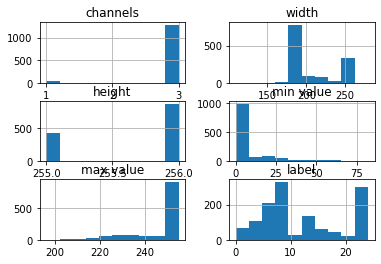

In [266]:
dataset_statistics(dataset_msl_test)

100%|██████████| 1640/1640 [00:00<00:00, 1657.80it/s]


       channels        width       height    min value    max value  \
count    1640.0  1640.000000  1640.000000  1640.000000  1640.000000   
mean        3.0   196.681098   255.687805     6.959756   243.294512   
std         0.0    18.701343     0.463530    15.206036    14.397112   
min         3.0   186.000000   255.000000     0.000000   168.000000   
25%         3.0   191.000000   255.000000     0.000000   231.000000   
50%         3.0   192.000000   256.000000     0.000000   252.000000   
75%         3.0   192.000000   256.000000     7.000000   255.000000   
max         3.0   256.000000   256.000000    97.000000   255.000000   

             label  
count  1640.000000  
mean     14.230488  
std       8.655528  
min       0.000000  
25%       5.000000  
50%      12.000000  
75%      24.000000  
max      24.000000  


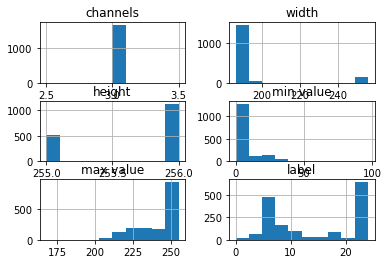

In [267]:
dataset_statistics(dataset_msl_val)

100%|██████████| 32368/32368 [03:22<00:00, 160.17it/s]


       channels    width   height     min value     max value        mean r  \
count   32368.0  32368.0  32368.0  32368.000000  32368.000000  32368.000000   
mean        3.0    500.0    560.0      1.441269    240.166615    152.275771   
std         0.0      0.0      0.0      6.971379     15.951936     25.624838   
min         3.0    500.0    560.0      0.000000     13.000000      2.506764   
25%         3.0    500.0    560.0      0.000000    228.000000    143.410379   
50%         3.0    500.0    560.0      0.000000    244.000000    157.060184   
75%         3.0    500.0    560.0      0.000000    255.000000    167.590146   
max         3.0    500.0    560.0    142.000000    255.000000    252.540079   

             mean g        mean b         std r         std g         std b  
count  32368.000000  32368.000000  32368.000000  32368.000000  32368.000000  
mean     128.002617     90.875876     29.826359     27.273408     22.747010  
std       21.737754     16.733596     10.050738      9

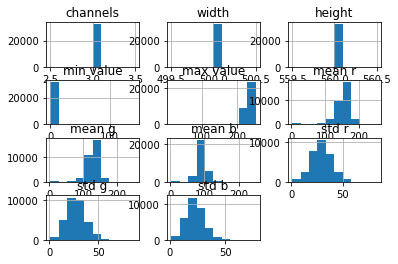

In [268]:
dataset_statistics(dataset_mars32k, rgb=True)

Conclusions: 
* Start with mars32k - its well behaved.
* May need to throw some data away to work with msl. Can chuck the single channel monochromes, cropping/padding/scaling height to 255-256 will probably save a lot of heartache, and working with the lower widths ~192 might help also.
* Ranges are in 0-255, so require 0-1 normalisation as a transform.

In [329]:
class TransformToFloat(object):
    """
    Need to do this before normalization, do it as a transform for
    ease
    """
    def __call__(self, image):
        return image.float()
    
class TransformNormalizeMars32k(object):
    """
    Hard code the normalization values into this transform pipeline
    """
    def __init__(self):
        self.normalize = transforms.Normalize(mean=[152.275771, 128.002617, 90.875876], 
                                               std=[29.826359, 27.273408, 22.747010])
        
    def __call__(self, image):
        return self.normalize(image)


In [330]:
# This is our simple preprocessing chain
transform_mars32k = transforms.Compose([
    TransformToFloat(),
    TransformNormalizeMars32k()
])

In [331]:
# Apply these transformations and double check
dataset_mars32k_trans = DatasetMars32k(fp_data_mars32k, transform=transform_mars32k)

In [332]:
dataset_mars32k_trans[0]

{'image': tensor([[[-3.9320, -3.8649, -3.8649,  ..., -4.5354, -4.4684, -4.4684],
          [-0.0092,  0.0243,  0.0578,  ..., -1.8533, -2.0544, -2.1885],
          [ 0.0243, -0.0092,  0.0243,  ..., -1.7862, -2.0879, -2.2221],
          ...,
          [-1.1156, -1.2498,  0.2925,  ..., -0.1769, -0.2775, -0.6463],
          [-1.9203, -2.4232, -1.1827,  ..., -0.5457, -1.0821, -1.9874],
          [-2.0209, -1.8868, -2.4567,  ..., -0.7468, -1.3168, -1.4845]],
 
         [[-4.4733, -4.4000, -4.4000,  ..., -4.6566, -4.5833, -4.5466],
          [-0.2934, -0.2568, -0.2201,  ..., -1.7234, -1.8700, -2.0167],
          [-0.3301, -0.3668, -0.3301,  ..., -1.5767, -1.9434, -2.0900],
          ...,
          [-1.3201, -1.4667,  0.2566,  ..., -0.1101, -0.0734, -0.4768],
          [-2.2000, -2.7500, -1.3567,  ..., -0.5134, -1.0267, -1.9434],
          [-2.3100, -2.1634, -2.7500,  ..., -0.8067, -1.2834, -1.3934]],
 
         [[-3.9951, -3.9951, -3.9951,  ..., -3.9071, -3.7313, -3.6873],
          [ 0.2692,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


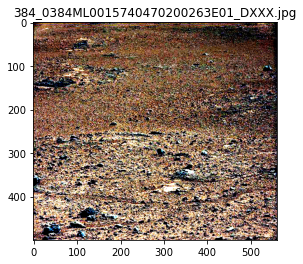

In [333]:
# Should be some clipping here
plot_instance(dataset_mars32k_trans[0])

100%|██████████| 32368/32368 [03:05<00:00, 174.14it/s]


       channels    width   height     min value     max value        mean r  \
count   32368.0  32368.0  32368.0  32368.000000  32368.000000  3.236800e+04   
mean        3.0    500.0    560.0     -4.500787      4.017685 -5.463865e-09   
std         0.0      0.0      0.0      0.493400      1.341371  8.591339e-01   
min         3.0    500.0    560.0     -5.105410     -3.467527 -5.021364e+00   
25%         3.0    500.0    560.0     -4.736608      2.994861 -2.972335e-01   
50%         3.0    500.0    560.0     -4.693312      3.742212  1.604088e-01   
75%         3.0    500.0    560.0     -4.267225      4.753334  5.134510e-01   
max         3.0    500.0    560.0      1.231268      7.215195  3.361600e+00   

             mean g        mean b         std r         std g         std b  
count  3.236800e+04  3.236800e+04  32368.000000  32368.000000  32368.000000  
mean  -2.693451e-07 -3.966615e-08      1.000000      1.000000      1.000000  
std    7.970310e-01  7.356394e-01      0.336975      0

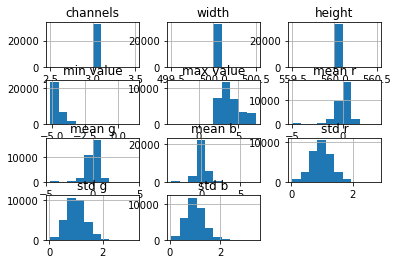

In [334]:
# The image's should on average have mean 0 and standard deviation 1 in all channels
dataset_statistics(dataset_mars32k_trans, rgb=True)

# Components
Require the following components:
* Image multi-cropper 
* Patch embedding module 
* Positional encoding (with interpolation)
* Transformer block (with multi-head attention)
* Transformer stack with CLS token
* Network wrapper (for student and teacher)
* DINO framework (with EMA distillation, temperature based softmax loss, and centering)
* Classification head (optional)

## Multi-cropper

In [350]:
class MultiCropper():
    """ 
    Objects of this class perform random multicropping during training in the DINO framework
    """
    
    def __init__(self,   global_size=224, local_size=96, 
                         n_global_crops=2, n_local_crops=8):
        """ 
        Global size (e.g. 224) is the side length of square crops from the images
        which represent the global scale. Local size (e.g. 96) is the side length
        of square crops from the images. They should have a common factor (e.g. 16)
        
        Local size should be less than global size. The number of local sizes (e.g. 8) 
        should be larger than the number of global sizes (e.g. 2)
        
        Use padding to ensure that the image size
        is always definitely the desired size (even if the image tensor is smaller than)
        """
        
        self.global_cropper = transforms.RandomCrop(global_size, pad_if_needed=True)
        self.local_cropper  = transforms.RandomCrop(local_size,  pad_if_needed=True)
        
        self.n_global_crops = n_global_crops
        self.n_local_crops  = n_local_crops
    
    def crop(self, image_tensor):
        """ 
        Take the provided floating point tensor (representing an image) and randomly cut 
        out the desired number and sized crops. Return them as two lists
        """
        
        def crop_helper(cropper, n):
            crops = []
            for i in range(n):
                crops.append(cropper(image_tensor))
            return crops
        
        global_crops = crop_helper(self.global_cropper, self.n_global_crops)
        local_crops  = crop_helper(self.local_cropper,  self.n_local_crops)
        
        # Return separately because it will be useful to do in different forward passes
        return global_crops, local_crops

In [351]:
# Quick check - confirm the number and size of returned crops is as expected
multicropper = MultiCropper()
crops = multicropper.crop(dataset_mars32k_trans[0]['image'])
print(len(crops[0]), len(crops[1]))
print(crops[0][0].shape)
print(crops[1][0].shape)

2 8
torch.Size([3, 224, 224])
torch.Size([3, 96, 96])


## Patch Embedding Module

In [372]:
class PatchEmbedding(nn.Module):
    """ 
    Takes a batch of image tensors and splits them each into N patches, and then
    embeds them into N, E-dimensional vectors / tokens
    """
    
    def __init__(self, in_channels=3, patch_size=16, embed_dim=768):  
        """
        By default, as in the DINO paper, we use RGB images with a desired patch size of 16, and 
        embedding dimension of 768
        """
        
        super().__init__()
        
        # This is not *really* a convolutional layer - it acts like an MLP but clever use
        # of the stride length here makes it easier embed non-overlapping patches 
        self.embedder = nn.Conv2d(in_channels, embed_dim, 
                                  kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        """ 
        A forward pass in this case takes an image with shape (B, C, W, H) and returns a batch
        which each has N patch embeddings with dimension E
        """
        
        # From (B, C, W, H) to (B, E, sqrt(N), sqrt(N))
        x = self.embedder(x)
        # to (B, E, N)
        x = x.flatten(2)
        # to (B, N, E)
        x = x.transpose(1,2)
        
        return x

In [374]:
# Quick check - we want to provide an 224 sized image and a 96 sized image and see what we get. Global
# sized patches should end up with 14^2=196 E-dimensional vectors, and local with 36
patch_embedder = PatchEmbedding()
global_batch_in = crops[0][0].unsqueeze(0)
print(global_batch_in.shape)
print(patch_embedder(global_batch_in).shape)
local_batch_in  = crops[1][0].unsqueeze(0)
print(local_batch_in.shape)
print(patch_embedder(local_batch_in).shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 196, 768])
torch.Size([1, 3, 96, 96])
torch.Size([1, 36, 768])


## Positional Encoding